# Two showcases of fraud detection models
The prospective fraud detection model will comprise of the order of ten separate fraud detection models. This document is meant to describe in some detail two such models to get an idea of how these models work, what they do with the data and what they result in. 

Both models use modern analytics techniques, as will the majority, but not all of the other models. The deliberate choice to develop two very different models has been made. Because in fraud detection for healthcare insurance we often don't have a large set of fraudulent claims or healthcare providers who have commited fraud before, many of the machine learning models are of the so-called unsupervised kind. In these, we can not train a model to recognize fraud, as we can't show it what fraud looks like. As such, models can only be used to mine the data for deviant patterns of any kind. Some of these deviant patterns are specifically looked for and based on business knowledge or clearly defined risks (for example, excessive costs per patient compared to similar care providers), and some may be "data driven", meaning that large deviations are detected independent of an explanation of what may be wrong with that specific customer. The two models in this report are both unsupervised machine learning models. One has a clearly defined definition of the financial risk, the other is just looking at billing patterns to see what's in there.

In [1]:
# Initialize the necessary software
import numpy as np
import numpy.random as rn
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
Axes3D
import seaborn as sns
import datetime as dt
import pickle, os, time, sys, itertools, string

%matplotlib inline

sns.set_context('talk')
sns.set_style('white')

rn.seed(42)

from IPython.display import display
from IPython.display import Image
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
# di.display_html('''<button onclick="jQuery('.input_area').toggle();jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

# Filter warnings (mostly deprecation anyway...)
import warnings
warnings.filterwarnings('ignore')

As a reminder, the data set looks like this, with one line per procedure:

In [2]:
# Load the data
datafile = './data/mock_healthcare.pickle'
df = open(datafile, 'rb')
data = pickle.load(df)
df.close()

In [3]:
data.head()

,Member_ID,Provider_ID,Procedure_code,Paid_amt,Treatment_date,Billing_date,Prov_specialism,Billing_party
0,8000000,1000000,A1,15.00,2016-01-19,2016-01-22,2,Patient
1,8000000,1000000,C1,127.06,2016-01-19,2016-01-22,2,Patient
2,8000000,1000000,E2,48.00,2016-01-19,2016-01-22,2,Patient
3,8000000,1000000,F1,130.00,2016-01-19,2016-01-22,2,Patient
4,8000001,1000000,A2,25.00,2016-04-22,2016-04-22,2,Provider


## Outliers in cost per patient
The first model will look at the average cost per patient (patients of the provider are members of the insurance companies and both terms will be used here) that providers claim. This is nothing else than the total billed amount, divided by the number of unique members for whom this was claimed. The build-up of that number is a combination of prizes of treatments, the number of treatments per person, the mix of treatments typically given, etc. and may therefore show a large variation.

The GUI will give the user the opportunity to pick an option for the grouping of providers when doing this model. The reason for that is that in practice an investigator would want to compare providers only to comparable providers, e.g. of the same specialism. Sometimes this is not known on beforehand (the "Prov_specialism" column will then be missing, empty or meaningless). In such cases you can determine the ourliers of the whole distribution of all available providers, or you can decide to let an algorithm decide the peer groups based on the mix of procedure codes they have billed. This will remove any outliers in that distribution, as the algorithm will not know to which group to compare these providers. The clustering of providers can not be checked on the fly, so this option should be used with caution (outliers tat you want to find may well be excluded based on their billing pattern, for the method, see the second example below).

The other option that can be set in the GUI is the method for determining an outlier. Three options are available:
- Above 90th percentile: this will generally result in many outliers. The upper 10%, roughly, of providers will be flagged. One reason to not use a very struct limit, but one that results in many flags is that this is very obvioulsy a financial risk, that any insurance company will want to have a handle on.
- Above 95th percentile: a common way of determining outliers is to take everyone above the 95th percentile.
- Statistical outlier: this is a method that is based on the actual distribution function of the providers. Whereas the method "above 95th percentile" makes a lot of sense for well-behaved near-normal distributions, this method does not assume anythin about the underlying distribution. The upper limit of acceptable values depends on the interquartile distance (the difference between the 25th percentil and 75th percentile). This results in points that are certainly deviant, but often results in only a few outliers.

In the example below we use the known specialisms, and flag every provider that is above the 95th percentile of its own reference group. In the plot there is a panel for each group (the difference between these distributions shows the necessity of using reference groups). The solid red line is the upper acceptabe limit, and every provider above this gets flagged. The highest occuring cost per member is, for convenience, indicated with the dotted red line.

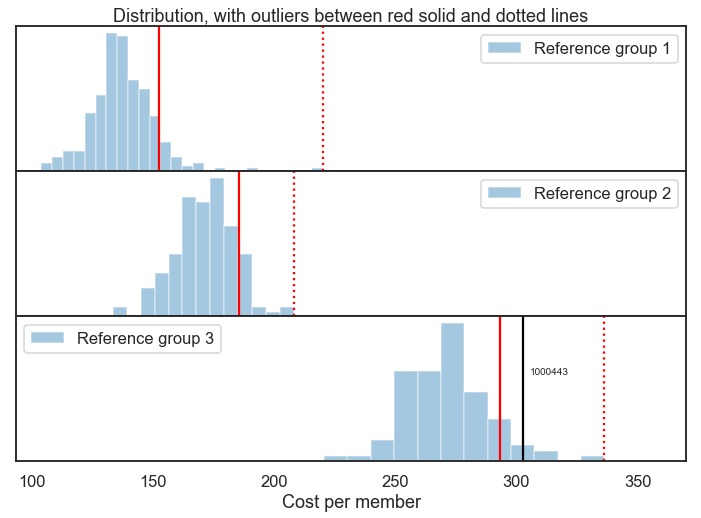

In [4]:
# Option to do overall, by known reference group, or by determined reference group
option_group = 'Per specialism'  # 'Overall', 'Per specialism', 'By determined peer group'
option_outlier = 'Above 90th percentile'  # 'Above 90th percentile', 'Statistical outlier', 'Above 95th percentile'

if option_outlier == 'Above 90th percentile': percentile = 90
elif option_outlier == 'Above 95th percentile': percentile = 95
elif option_outlier == 'Statistical outlier': pass  # Outside upper inner fence = q3+ 1.5*(q3-q1)
else: print("Not yet implemented!")

if option_group == 'By determined peer group':
    # Groups need to be determined
    piv_proc = pd.pivot_table(data, values='Paid_amt', index='Provider_ID', columns='Procedure_code', aggfunc='sum')
    piv_proc.replace(np.nan, 0, inplace=True)
    fractional_proc = piv_proc.div(piv_proc.sum(axis=1), axis=0)
    
    from sklearn.decomposition import PCA
    pca=PCA()
    manifolds = pca.fit_transform(fractional_proc)[:,:3]
    
    from sklearn.cluster import DBSCAN
    from sklearn.preprocessing import StandardScaler
    X = StandardScaler().fit_transform(manifolds)
    results = DBSCAN().fit(X)
    
    #This is one label per provider, in order, so I have to join these to the dataframe
    tojoin = pd.DataFrame({'IDs':piv_proc.index, 'refgroup':results.labels_})
    data = data.merge(tojoin, how='left', left_on='Provider_ID', right_on='IDs')
    
elif option_group == 'Overall': data['refgroup'] = np.zeros(len(data.index))
elif option_group == 'Per specialism': data['refgroup'] = data.Prov_specialism
else: 
    print("The option for reference groups is not recognized! Overall is used.")
    refgroup = np.zeros(len(data.index))
    data['refgroup'] = refgroup

refgroups = np.unique(data.refgroup)


outliers = []
score = []
money = []

plt.figure(figsize=(12,8))
plt.subplots_adjust(hspace=0.000)
number_of_subplots=len(refgroups)

maxval = 0
minval = 1e9
for iref, ref in enumerate(refgroups):
    if ref == -1 and option_group == 'By determined peer group': continue   # These are outliers determined by DBSCAN
    thisgroup = data[data.refgroup == ref]
    prov_pat = thisgroup.groupby(['Provider_ID', 'Member_ID'])
    cost_all_patients = pd.DataFrame(prov_pat.Paid_amt.sum())
    cost_all_patients.reset_index(inplace=True)
    per_prov = cost_all_patients.groupby('Provider_ID')
    cost_per_member = per_prov.Paid_amt.mean()
    number_patients = per_prov.Paid_amt.count()
    if cost_per_member.max() > maxval: maxval = cost_per_member.max()
    if cost_per_member.min() < minval: minval = cost_per_member.min()
    ax = plt.subplot(number_of_subplots, 1, iref+1)
    ax.set_yticks([])
    if option_group == 'Per specialism': plabel = str('Reference group ')+str(ref)
    elif option_group == 'By determined peer group': plabel = str('Reference group'+str(ref+1))
    elif option_group == 'Overall': plabel = ''
    else: plabel = ''
    sns.distplot(cost_per_member, kde=False, label=plabel)
    if not plabel == '': ax.legend(loc='best')
    if iref == number_of_subplots-1:
        ax.set_xlabel("Cost per member")
    else: ax.set_xticks([])
    if iref == 0: ax.set_title("Distribution, with outliers between red solid and dotted lines")
    # Overplot an outlier with a line.
    if option_outlier in ['Above 90th percentile', 'Above 95th percentile']:
        limval = np.percentile(cost_per_member, percentile)
    elif option_outlier == 'Statistical outlier':
        q1, q3 = np.percentile(cost_per_member, [25, 75])
        limval = q3 + 1.5 * (q3-q1)
    else: 
        print("Outlier option not yet implemented!", option_outlier, "Using 90th percentile")
        limval = np.percentile(cost_per_member, 90)
    
    median = np.median(cost_per_member)

    ylims = ax.get_ylim()
    ax.plot([limval, limval], ylims, color='red')
    ax.plot([cost_per_member.max(), cost_per_member.max()], ylims, 'r:' )

    toomuch = cost_per_member[cost_per_member > limval]
    scoring_entities = toomuch.index
    outliers.extend(list(scoring_entities))

    score.extend(list((toomuch - limval) / np.abs(limval - median)))

    npats = number_patients[scoring_entities].values
    money.extend(list((toomuch-limval)*npats))
    ax.set_ylim([ylims[0], ylims[1]])
    
# Adjust all axis ranges
for axi in range(1, number_of_subplots+1):
    ax = plt.subplot(number_of_subplots, 1, axi)
    ax.set_xlim([.9*minval, 1.1*maxval])

    if axi == 3: 
        ys = ax.get_ylim()
        ax.plot([toomuch.values[-1], toomuch.values[-1]], [ys[0],ys[1]], "k-")
        ax.text( 1.01* toomuch.values[-1], .6*ys[1], toomuch.index[-1])
#         ax.set_ylim([ys[0], ys[1]])



For all providers between the red vertical lines we calculate a score and a corresponding monetary amount. The score is based on how far above the limit you are, corrected for the width of the distribution (so being equally far above the limit of a narrower distribution is more severe than for a narrower distribution). The monetary amount is equal to the difference in cost per member between the upper limit (vertical red solid line) and the cost per member of the flagged provider, multiplied with the number of members the particular has billed for.

For this particular example we arrive at a list with the following properties. For other settings this may be different!

In [5]:
print("The total number of providers that is flagged is", len(outliers))
print("Scores vary from", np.round(np.min(score), 3), "to", np.round(np.max(score), 2), "with an average of", np.round(np.mean(score), 2))

The total number of providers that is flagged is 52
Scores vary from 0.001 to 4.23 with an average of 0.54


These scores are, in all models, constructed such that their normalization is roughly equal: the same number for the score should roughly correspond to an equally "severe" outlier. This ensures that the weights (that can be set in the GUI) can actually be regarded as actual relative weights of the different model ingredients.

## Billing patterns
In the data, we have included a total number of 18 different procedure codes. Which of these is billed (and, presumably, corresponds to the actual treatment patients have received) depends strongly on the specialism, but even within specialisms there is an appreciable spread. Some of these procedure codes correspond to fixed price treatments, whereas in other cases there is a free (perhaps hourly) billing scheme. Therefore, the fraction of the revenue of a provider that is due to any particular procedure code can have a large range of values.

By billing pattern we mean different fractions of a provider's revenue that is due to all the different procedures. These may include zeros for procedures the provider never does and add up to 1 (the full revenue is due to all the billed procedure codes together). A provider can thus be specified by a point in the 18-dimensional space, where in all dimensions the coordinate is between zero and one.

Finding groups in 18-dimensional spaces is not a trivial task, ask it can not be visualized easily. Even for an algorithm, clustering in so many dimensions is hard for a variety of reasons that we won't go into in detail here. 

The different specialisms are expected to follow a pattern that within a specialism is fairly similar, whereas the different specialisms differ from one another. What we do here is that we use dimensionality reduction techniques to represent the 18-dimensional space of the billing patterns into a three-dimensional one, in order to be able to visualize it more easily. We find clusters in that three-dimensional representation as well, and flag all providers that are not in a dense group. The total number of dense groups that is expected is equal to the number of specialisms. This is not guaranteed, as some specialisms may look alike (in the full 18-dimensional space, or in its three-dimensional representation), or because sub-groups within a specialism have different billing patterns as well.

In the images below, the members of the same clusters have the same color. The outliers are overplotted with slightly larger symbols in red. These providers are too far from the cluster centers where all other providers reside, which implies that their mox of procedure codes is far off the norm for any of the known specialisms.

In [6]:
# Create a pivot table with amounts per procedure code for all providers, then normalize
piv_proc = pd.pivot_table(data, values='Paid_amt', index='Provider_ID', columns='Procedure_code', aggfunc='sum')
piv_proc.replace(np.nan, 0, inplace=True)
fractional_proc = piv_proc.div(piv_proc.sum(axis=1), axis=0)

In [7]:
# Create a lookup for the specialism
prov_spec = data.loc[:,['Provider_ID', 'Prov_specialism']].drop_duplicates()
prov_spec.set_index('Provider_ID', inplace=True)
specs = np.array(prov_spec.values)


In [8]:
from sklearn.decomposition import PCA
pca=PCA()
pcas = pca.fit_transform(fractional_proc)

In [9]:
from sklearn.cluster import DBSCAN
scanner = DBSCAN(eps=2)
results = scanner.fit(pcas[:,:2])

In [10]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(pcas[:,:3])
scanner = DBSCAN(eps=0.5)
results = scanner.fit(X)

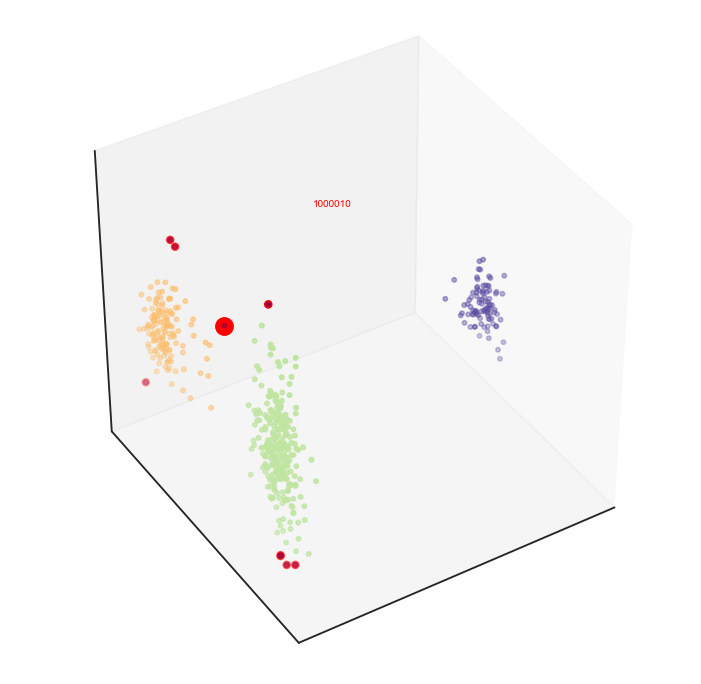

In [11]:
fig=plt.figure(figsize=(12, 12))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(pcas[:, 0], pcas[:, 1], pcas[:, 2], c=results.labels_, cmap=plt.cm.Spectral)
ax.view_init(40, -122)
ax.scatter(pcas[results.labels_ == -1, 0], pcas[results.labels_ == -1, 1], pcas[results.labels_ == -1, 2], c='red', s=50)
ax.scatter(pcas[results.labels_ == -1, 0][0], pcas[results.labels_ == -1, 1][0], pcas[results.labels_ == -1, 2][0], c='red', s=300)
ax.text(.2, .1, .1, piv_proc.index[results.labels_ == -1][0], color='red')
ax.set_xticks([])
ax.set_yticks([])
zt = ax.set_zticks([])

# plt.savefig('billing_pattern_3D.png', dpi=400)

The three-dimensional representation above is already clear enough, but for completeness, we also show two projections of this distribution below. Numbers along these axes would not mean much.

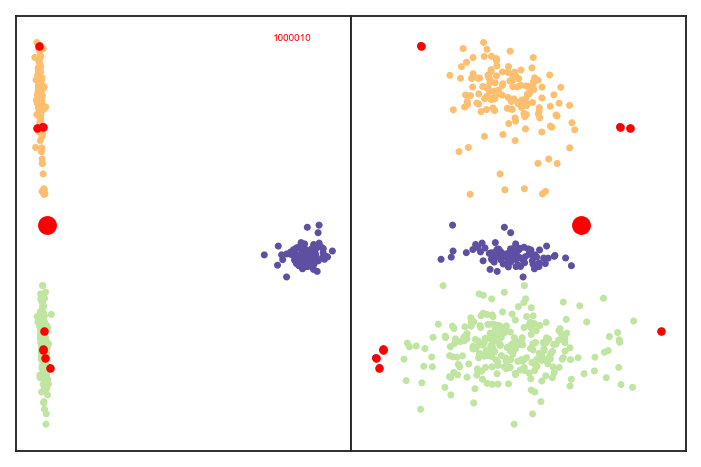

In [12]:
plt.figure(figsize=(12, 8))
plt.subplots_adjust(wspace=0.000)

ax = plt.subplot(121)
plt.scatter(pcas[:,0], pcas[:,1], c=results.labels_, s=30, cmap=plt.cm.Spectral)
plt.scatter(pcas[results.labels_ == -1,0], pcas[results.labels_ == -1,1], c='red', s=50)
plt.scatter(pcas[results.labels_ == -1,0][0], pcas[results.labels_ == -1,1][0], c='red', s=300)
xs, ys = ax.get_xlim(), ax.get_ylim()
ax.text(.7*xs[1], .9*ys[1], piv_proc.index[results.labels_ == -1][0], color='red')

ax.set_xticks([])
ax.set_yticks([])
ax = plt.subplot(122)
plt.scatter(pcas[:,2], pcas[:,1], c=results.labels_, s=30, cmap=plt.cm.Spectral)
plt.scatter(pcas[results.labels_ == -1,2], pcas[results.labels_ == -1,1], c='red', s=50)
plt.scatter(pcas[results.labels_ == -1,2][0], pcas[results.labels_ == -1,1][0], c='red', s=300)
ax.set_xticks([])
ticks = ax.set_yticks([])


In [13]:
print("The number of outliers based on their billing pattern is", len(results.labels_[results.labels_ == -1]))

The number of outliers based on their billing pattern is 9


The outliers here get a score that depends on their distance to the nearest cluster center, relative to the cluster size (so scores are lower if an outlier is closer to a group, and for the same distance to the cluster center the score is lower if the nearest group is more diffuse). A monetary score is not very meaningful for this model, so all corresponding monetary amounts will be set to zero.

## Where does this all go?
In the overall model, the user can set all model parameters that are useful for a user to vary. These models are then run with those particular settings. When all models are run, the resulting scores and corresponding monetary amounts are collected and a "hit list" of providers is constructed based on the (weighted) total score and (weighted) monetary amount. This list should, after proper tweaking of model weights and model options, represent a fair assessment of the fraud risk of this database of (healthcare) bills.